In [2]:
# Connecting Google Colab to Google Drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD


In [4]:
import os
import random

# Directory where the image files are stored
directory_path = '/content/gdrive/MyDrive/Augmented Data'

# Distribution of images per label
total_images = {'Normal': 2446, 'Malignant': 2309, 'Benign': 2532}

# Ratios for splitting the data
split_ratios = {
    'Training': 0.60,
    'Validation': 0.20,
    'Testing': 0.20
}

# Function to calculate split counts
def calculate_split_counts():
    split_counts = {split: {} for split in split_ratios}
    for label, count in total_images.items():
        for split, ratio in split_ratios.items():
            split_counts[split][label] = round(count * ratio)
    return split_counts

split_counts = calculate_split_counts()

# Load filenames and extract labels
filenames = os.listdir(directory_path)
labels = [f.split('_')[1] for f in filenames]

# Combine filenames and labels into a single list of tuples
data = list(zip(filenames, labels))

# Separate data by labels
data_by_label = {}
for file, label in data:
    if label not in data_by_label:
        data_by_label[label] = []
    data_by_label[label].append((file, label))

# Shuffle and split data
def shuffle_and_split(data_by_label, split_counts):
    train, val, test = [], [], []
    for label, files in data_by_label.items():
        random.shuffle(files)
        train_end = split_counts['Training'][label]
        val_end = train_end + split_counts['Validation'][label]
        train.extend(files[:train_end])
        val.extend(files[train_end:val_end])
        test.extend(files[val_end:])
    return train, val, test

train, val, test = shuffle_and_split(data_by_label, split_counts)

# Function to print counts per label in each set
def print_counts(data_split, name):
    count = {}
    for _, label in data_split:
        if label not in count:
            count[label] = 0
        count[label] += 1
    print(f"Counts for {name}: {count}")

# Print the counts for each set
print_counts(train, "Training")
print_counts(val, "Validation")
print_counts(test, "Testing")


Counts for Training: {'Normal': 1468, 'Benign': 1519, 'Malignant': 1385}
Counts for Validation: {'Normal': 489, 'Benign': 506, 'Malignant': 462}
Counts for Testing: {'Normal': 489, 'Benign': 507, 'Malignant': 462}


In [12]:
import tensorflow as tf

def load_and_preprocess_image(path, label):
    # Load the image file
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [64, 64])  # Resize the image to 64x64
    image /= 255.0  # Normalize image pixels to [0, 1]

    # Encode label (Assuming 'Malignant' is 1 and 'Benign' is 0)
    label = 1 if label == 'Malignant' else 0
    return image, label


def prepare_dataset(data, batch_size=32):
    # Paths and labels
    paths = [os.path.join(directory_path, fname) for fname, _ in data]
    labels = [label for _, label in data]
    # Create a dataset from tensor slices
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    # Map the loading function
    dataset = dataset.map(load_and_preprocess_image)
    # Shuffle, batch, and prefetch
    dataset = dataset.shuffle(buffer_size=len(paths))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Convert train, validation, and test lists to datasets
train_dataset = prepare_dataset(train)
val_dataset = prepare_dataset(val)
test_dataset = prepare_dataset(test)


In [13]:
def create_model():
    model = Sequential([
        Flatten(input_shape=(64, 64, 3)),  # Flatten the input images to a vector
        Dense(512, activation='relu'),     # First dense layer with 512 neurons
        Dense(256, activation='relu'),     # Second dense layer with 256 neurons
        Dense(128, activation='relu'),     # Third dense layer with 128 neurons
        Dense(64, activation='relu'),      # Fourth dense layer with 64 neurons
        Dense(1, activation='sigmoid')     # Output layer with sigmoid activation for binary classification
    ])
    return model


In [14]:
model = create_model()
model.compile(optimizer=SGD(learning_rate=0.0001),  # Stochastic Gradient Descent optimizer with a learning rate of 0.01
              loss='binary_crossentropy',         # Loss function for binary classification
              metrics=['accuracy'])               # Metric to monitor is accuracy


In [15]:
history = model.fit(train_dataset,          # Training dataset
                    epochs=20,              # Total number of epochs to train
                    validation_data=val_dataset)  # Validation dataset for monitoring validation loss and accuracy


Epoch 1/20
137/137 [==============================] - 1042s 2s/step - loss: 0.7396 - accuracy: 0.3676 - val_loss: 0.6901 - val_accuracy: 0.5402
Epoch 2/20
137/137 [==============================] - 30s 110ms/step - loss: 0.6670 - accuracy: 0.6363 - val_loss: 0.6489 - val_accuracy: 0.6822
Epoch 3/20
137/137 [==============================] - 25s 77ms/step - loss: 0.6387 - accuracy: 0.6825 - val_loss: 0.6312 - val_accuracy: 0.6815
Epoch 4/20
137/137 [==============================] - 24s 75ms/step - loss: 0.6252 - accuracy: 0.6828 - val_loss: 0.6224 - val_accuracy: 0.6822
Epoch 5/20
137/137 [==============================] - 24s 74ms/step - loss: 0.6179 - accuracy: 0.6828 - val_loss: 0.6170 - val_accuracy: 0.6829
Epoch 6/20
137/137 [==============================] - 25s 83ms/step - loss: 0.6130 - accuracy: 0.6830 - val_loss: 0.6130 - val_accuracy: 0.6829
Epoch 7/20
137/137 [==============================] - 25s 79ms/step - loss: 0.6089 - accuracy: 0.6832 - val_loss: 0.6094 - val_accuracy

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)


In [18]:
import matplotlib.pyplot as plt


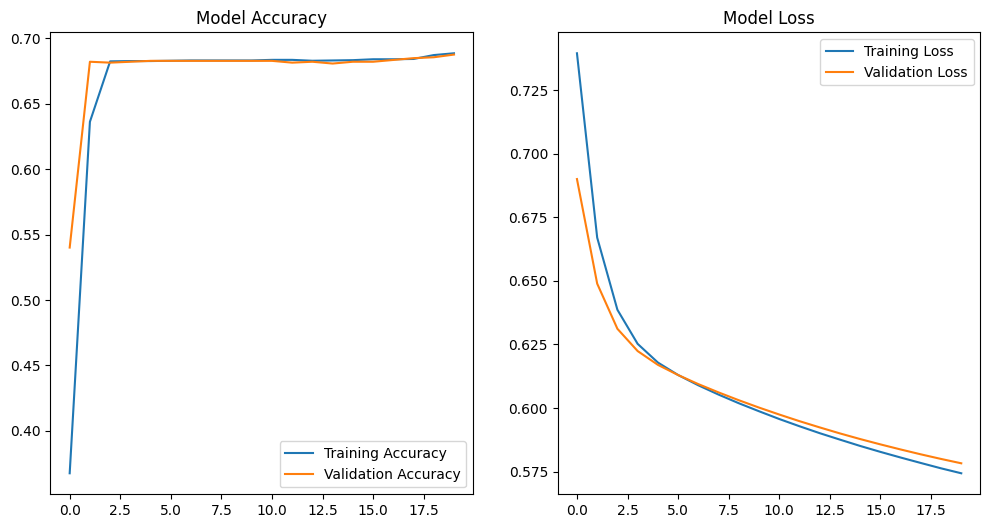

In [20]:
# Plot training and validation history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

In [21]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


46/46 [==============================] - 273s 15ms/step - loss: 0.5785 - accuracy: 0.6872
Test Loss: 0.578482985496521
Test Accuracy: 0.6872428059577942


In [22]:
# Making predictions on the test dataset
predictions = model.predict(test_dataset)

# If your model ends with a sigmoid activation (binary classification), you might want to apply a threshold
# Here we assume a threshold of 0.5 for binary classification
predicted_classes = (predictions > 0.5).astype(int)

# Print the first few predictions
print("Predictions:\n", predicted_classes[:10])


46/46 [==============================] - 6s 25ms/step
Predictions:
 [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


In [24]:
from sklearn.metrics import classification_report, confusion_matrix

# Assume you can extract the true labels from the test_dataset
# You may need to adjust this depending on how your data is structured
true_labels = []
for images, labels in test_dataset.unbatch().take(len(predictions)):
    true_labels.append(labels.numpy())

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)


# Generate a classification report
cr = classification_report(true_labels, predicted_classes, target_names=['Class 0', 'Class 1'])
print("Classification Report:\n", cr)


Classification Report:
               precision    recall  f1-score   support

     Class 0       0.68      0.98      0.80       996
     Class 1       0.27      0.02      0.03       462

    accuracy                           0.67      1458
   macro avg       0.47      0.50      0.42      1458
weighted avg       0.55      0.67      0.56      1458



In [26]:
import seaborn as sns  # For a nicer confusion matrix visualization


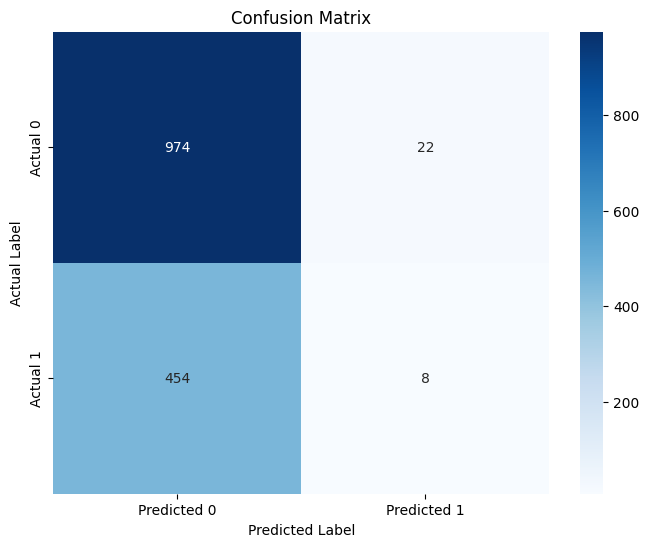

In [27]:
# Plotting using matplotlib and seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, matthews_corrcoef


In [33]:


# Calculate MSE
mse = mean_squared_error(true_labels, predicted_classes)
print("Mean Squared Error (MSE):", mse)

# Calculate MAE
mae = mean_absolute_error(true_labels, predicted_classes)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 0.32647462277091904
Mean Absolute Error (MAE): 0.32647462277091904


In [35]:
# Assuming 'history' is the object returned by model.fit()
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)


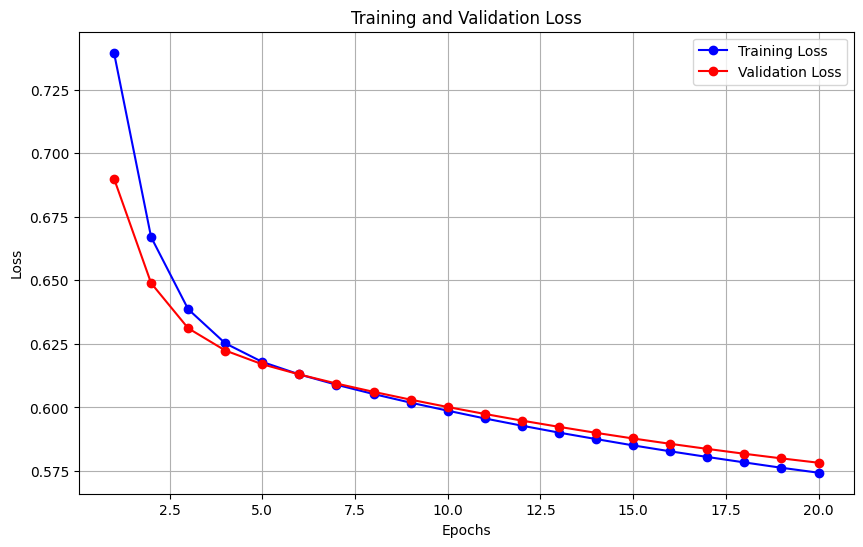

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')  # 'bo-' gives blue color with circle markers and a solid line
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')  # 'ro-' gives red color with circle markers and a solid line
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
